### Final Models and Evaluation

-------

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def rmse(model, X, y):
    model_preds = model.predict(X)
    mse = mean_squared_error(y, model_preds)
    return mse ** 0.5

In [3]:
df = pd.read_csv('../datasets/cleaned_housing_data.csv', keep_default_na=False, na_values=[''])
test = pd.read_csv('../datasets/test.csv', keep_default_na=False, na_values=[''])
pd.options.display.max_columns = 99
df = df.drop(columns=['Unnamed: 0'])

In [4]:
features_A=[
    'Overall Qual',
    'Overall Cond',
    'Year Built',
    'Year Remod/Add',
    'Total Bsmt SF',
    '1st Flr SF',
    'Gr Liv Area',
    'TotRms AbvGrd',
    'Fireplaces',
    'Garage Yr Blt',
    'Garage Area'
]

In [5]:
num_features = features_A + ['Mas Vnr Area', 'Full Bath', 'BsmtFin SF 1', 'Garage Cars']

In [6]:
ohe_features = [
    'MS Zoning', 
    'Neighborhood', 
    'Condition 1',
    'Condition 2',
    'Land Contour',
    'Kitchen Qual'
]

features = num_features + ohe_features

In [7]:
#Define predictor and target variable(s):
X=df[features]
y=df['SalePrice']

In [8]:
#train test split:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
#Instantiate and Fit One Hot Encoder to utilize categorical features:

ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(X_train[ohe_features])

#convert training categorical columns
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train[ohe_features]),
    columns=ohe.get_feature_names(ohe_features)
)

#convert testing categorical columns
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[ohe_features]),
    columns=ohe.get_feature_names(ohe_features)
)

In [10]:
#Adding one hot encoded columns to train test split X's
X_train_full = pd.concat([X_train.reset_index(drop=True), X_train_ohe], axis=1).drop(columns=ohe_features)
X_test_full = pd.concat([X_test.reset_index(drop=True), X_test_ohe], axis=1).drop(columns=ohe_features)

In [11]:
#Fit and Score Pipeline
pipe=Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=False, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe.fit(X_train_full, y_train)
pipe.score(X_train_full, y_train), pipe.score(X_test_full, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished
/Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+09, tolerance: 8.121e+08
  model = cd_fast.enet_

(0.9706598363598034, 0.9256822201252949)

In [12]:
rmse(pipe, X_train_full, y_train), rmse(pipe, X_test_full, y_test)

(14126.530709645056, 22157.07605736612)

-----

By toggling PolynomialFeatures's argument "interaction_only" from False to True I sought to dimish some overfitting still present in my model but the resulting scores and rmse were almost negligible in difference. I will include this version of the final model below:

-----

In [13]:
#Fit and Score Pipeline (Same as above except interaction_only=True)
pipe2=Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe2.fit(X_train_full, y_train)
pipe2.score(X_train_full, y_train), pipe2.score(X_test_full, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
........................................................................................................................................................................................................................................................................................................./Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.102e+08, tolerance: 6.420e+08
  model = cd_fast.enet_coordinate_descent(
...........................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapse

(0.9767290842570977, 0.9094053482731476)

In [14]:
rmse(pipe2, X_train_full, y_train), rmse(pipe2, X_test_full, y_test)

(12580.879101181486, 24463.430879587053)

------

### Model Evaluation

#### Pipe1: RMSE (train, test) = (14126.53, 22157.08); R2 (train, test) = (0.97, 0.93)
#### Pipe2: RMSE (train, test) = (12580.88, 24463.43); R2 (train, test) = (0.98, 0.91)
#### Honorable Mention RMSE = (21610, 23154); R2 = (0.93, 0.92)

Overall, final model yields strong scores against tthe trrain datta but undeniably is overfit and introduces high variance and low ability to generalize. Throughout this project test_split R2's never fail to fall significantly (>2%) short of train_split values, particularly in the instances of polynomial features which is most cases. PF introduces a high degree of model complexity and Lasso Regression does not act as a panacea solving all of my bias-variance tradeoff woes. A tempering of the use of polynomial features,, further experimentation with Ridge regression fitting and an analysis of implicit colinearity between features in models can all contribute to improved model performance. Besidess parameter tuning and alternate model methodologies, greater care can be taken to recttifying issues within the dataset itself as outlier values within features that could be major culprits behind variance were mostly ignored in our cleaning and EDA in favor of the intuitive "Homebuyer first, Data Scientist second" approach that I attempt to guide mmy analysis with in order to answer my problem statement.

That being said, my ability to use my homemade feature qualification crriteria as the basis to include and exclude features from models worked far better than I expected it too with top ranked features routinely remaining within models and contributed to overall strong performance and solid metrics against the train data.

In [15]:
#get test predictions
y_preds = pipe.predict(X_test_full)

In [16]:
#calculate residuals
residuals = y_test - y_preds

In [17]:
price_df = pd.DataFrame({
    "PredPrice": y_preds.round(0),
    "SalePrice": y_test,
    "Residuals": residuals
})

price_df.sort_values(by='SalePrice',ascending=False).head(10)

,PredPrice,SalePrice,Residuals
1524,491194.0,591587,100392.640433
631,532624.0,538000,5376.064884
1315,510406.0,485000,-25406.096811
527,401935.0,468000,66064.886262
722,475156.0,455000,-20155.612740
906,432728.0,438780,6052.177461
832,432567.0,426000,-6566.915706
1574,381435.0,425000,43564.686895
1079,368044.0,410000,41956.462309
218,371074.0,410000,38925.531654


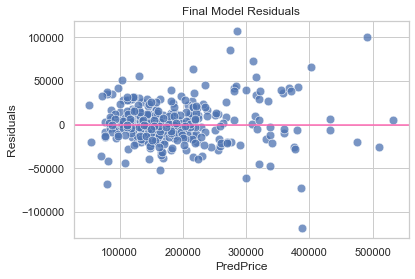

<Figure size 432x288 with 0 Axes>

In [18]:
#plot residuals
sns.figsize=(100,150)
sns.set_theme(style='whitegrid')
sns.scatterplot(x='PredPrice', y='Residuals', data=price_df ,s=75, alpha=0.75)
plt.axhline(0, color = 'hotpink');
plt.title("Final Model Residuals") 
plt.show()
plt.savefig('../images/Residuals.png')

This plot shows how model performance breaks down at the upper bounds of price. The higher residuals are indicative of the model's shortcomings encapsulating all the value in a higher end home with only the features available to it. Because the best model still overfits to some degree it is not easily generalized on unseen data with kaggle scores underperforming compared to train/test split scores.

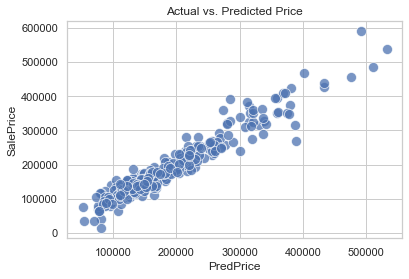

In [19]:
#plot predicted vs. actual price:
sns.figsize=(100,150)
sns.set_theme(style='whitegrid')
sns.despine(left=True, bottom=True)
sns.scatterplot(x='PredPrice', y='SalePrice', data=price_df, s=100, alpha=0.75).set(title='Actual vs. Predicted Price');
plt.savefig('../images/ActualVsPredictPrice.png')

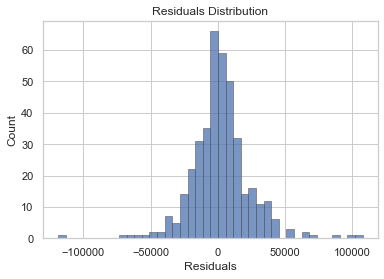

In [20]:
#Histogram of Residuals
sns.histplot(
    price_df,
    x="Residuals",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
)
plt.title('Residuals Distribution');

In [21]:
lasso_coefs = pipe.named_steps['lr'].coef_

In [22]:
coef_df = pd.DataFrame(lasso_coefs, index = pipe.named_steps['pf'].get_feature_names(X_train_full.columns), columns=['coef val'])

In [23]:
nonzero_coef = coef_df[coef_df['coef val'] !=0]

In [24]:
#nonzero_coef.plot.bar(figsize=(100, 70));

-----

#### Pipe3: Honorable Mention; 'A tier numeric data' model

In [25]:
features = features_A + ['Mas Vnr Area', 'Full Bath', 'BsmtFin SF 1', 'Garage Cars']

In [26]:
#Define predictor and target variable(s):
X=df[features]
y=df['SalePrice']

In [27]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [28]:
pipe3 = Pipeline([
    ('ss', StandardScaler()),
    ('pf', PolynomialFeatures(interaction_only=False, include_bias=False)),
    ('lr', LassoCV(verbose=True))
])

pipe3.fit(X_train, y_train)
pipe3.score(X_train, y_train), pipe3.score(X_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
/Users/kevingates/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e+09, tolerance: 8.121e+08
  model = cd_fast.enet_

(0.9313352958324199, 0.9188377542426759)

In [29]:
#Calculate rmse for train test splits
rmse(pipe3, X_train, y_train), rmse(pipe3, X_test, y_test)

(21610.809185260536, 23154.910813046903)

In [30]:
pipe3_coefs = pd.DataFrame(pipe3.named_steps['lr'].coef_, index = pipe3.named_steps['pf'].get_feature_names(X_train.columns), columns=['coef val'])

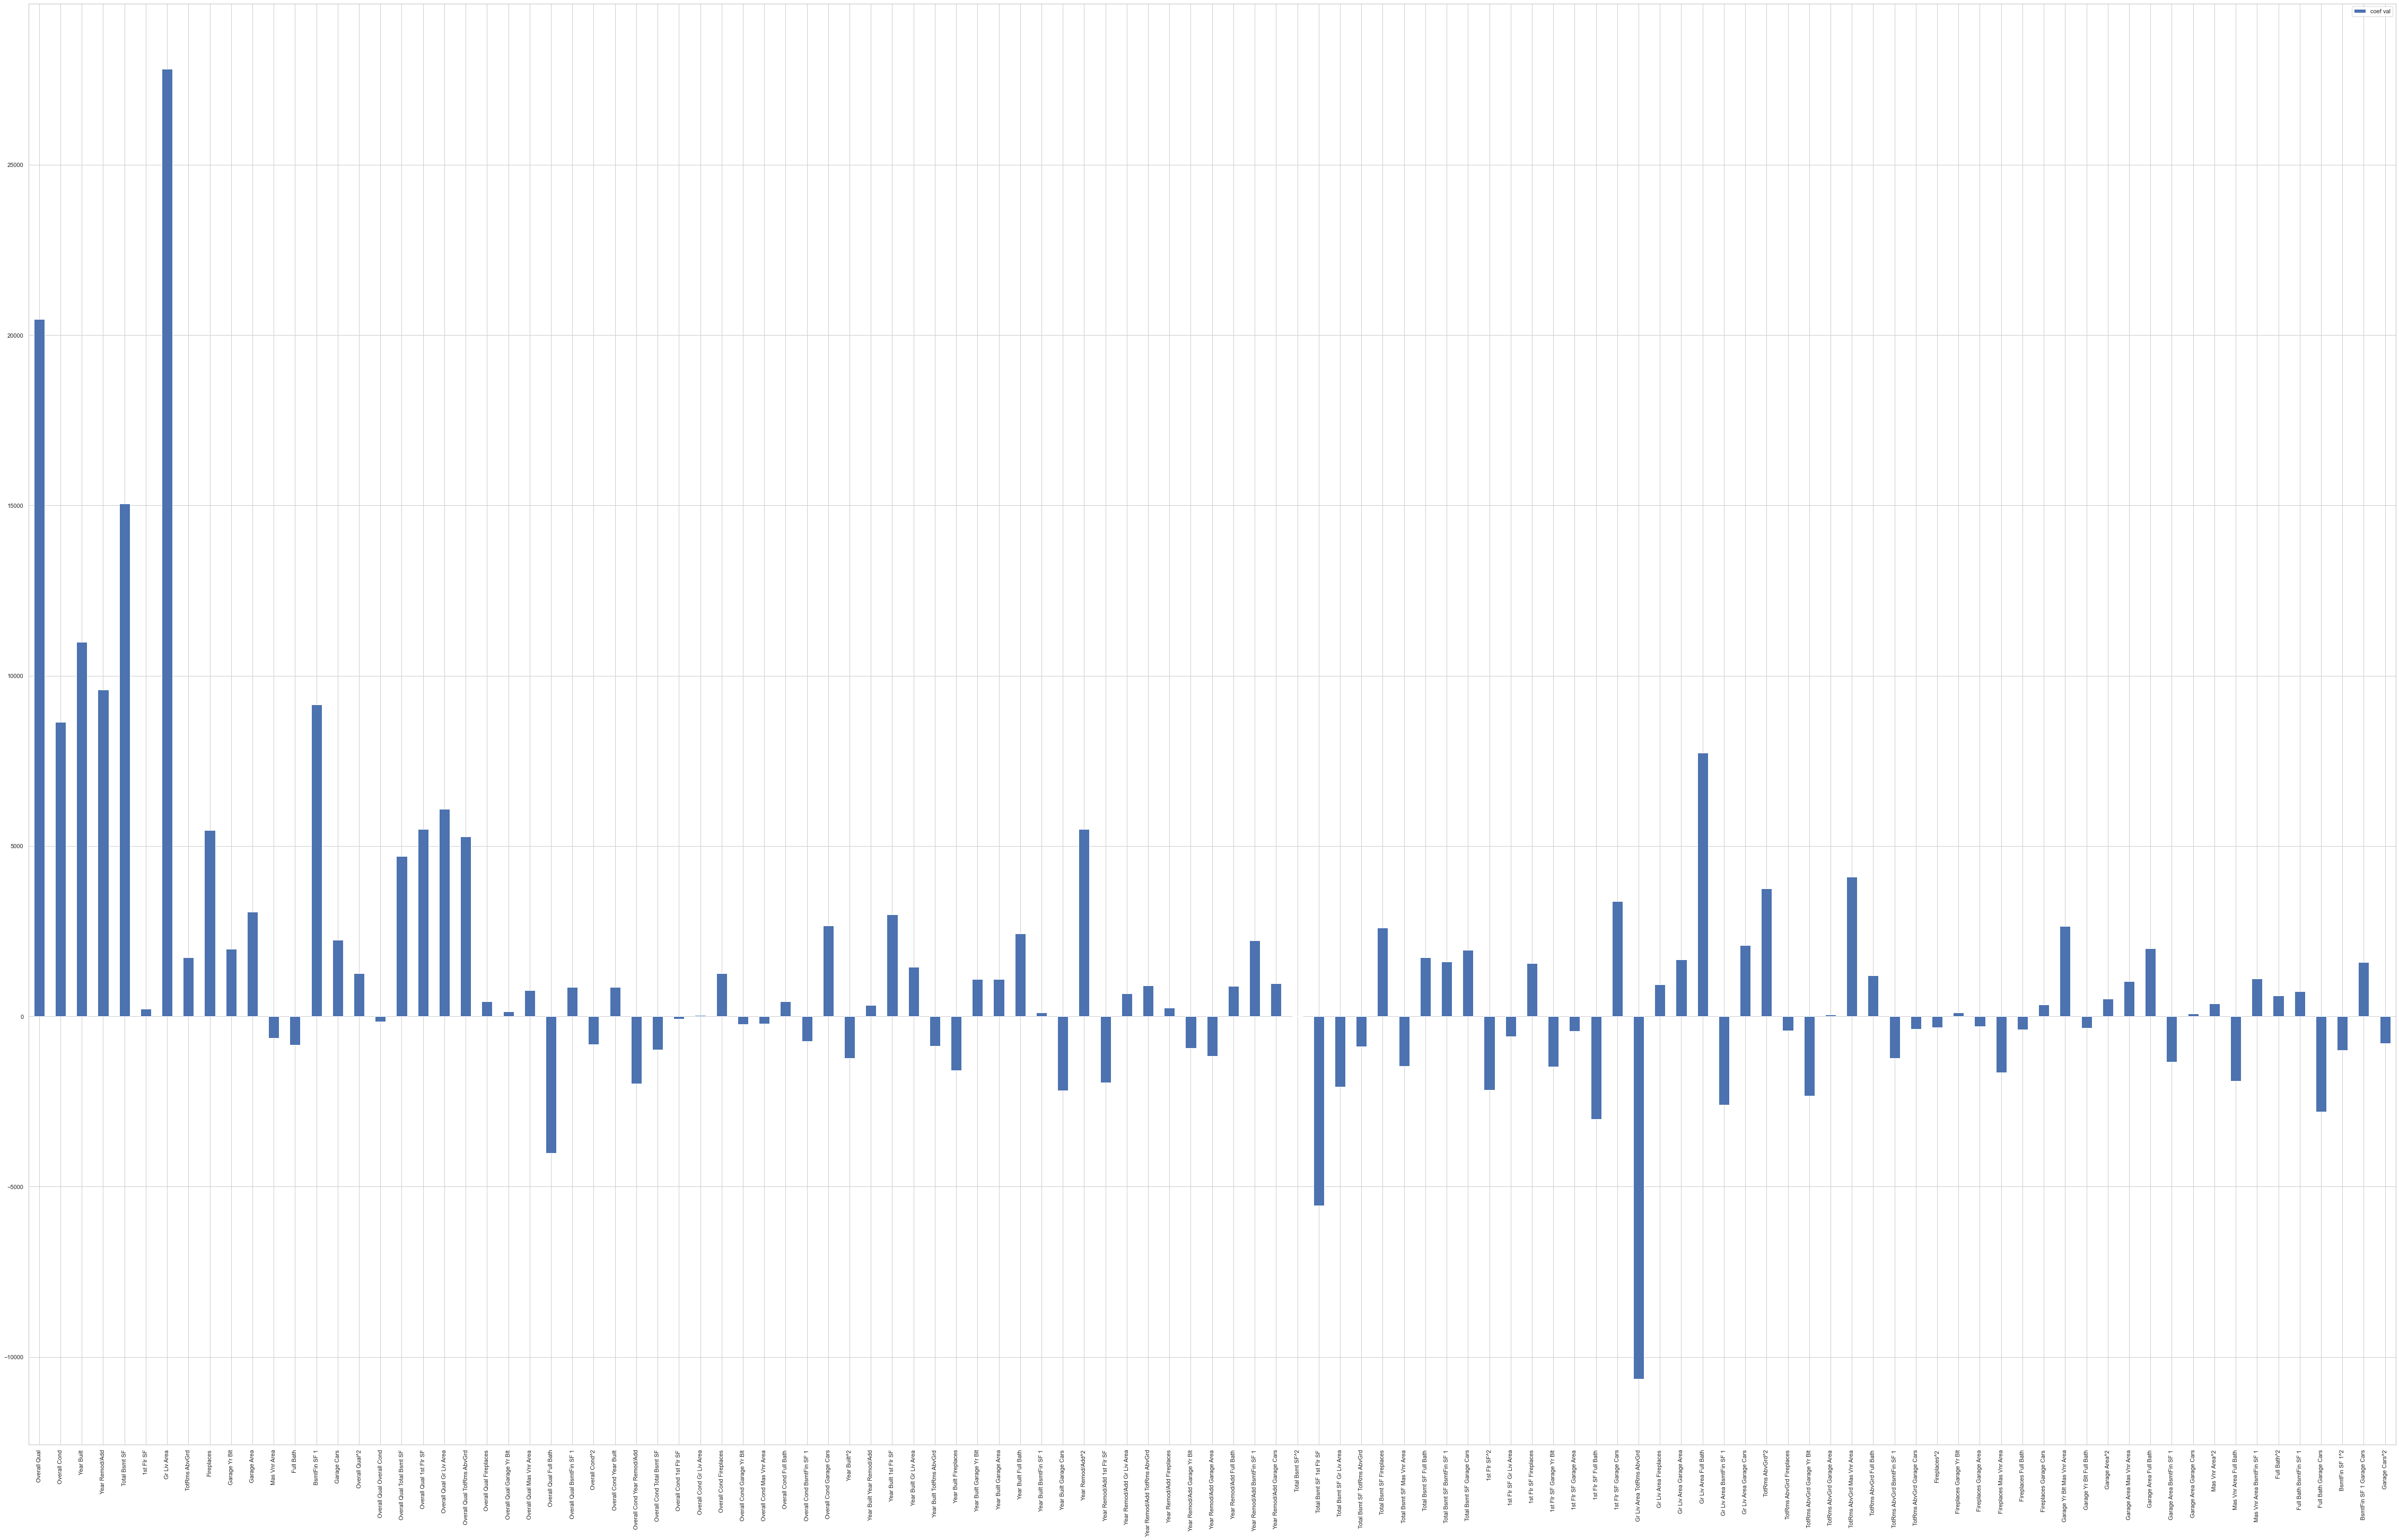

In [31]:
pipe3_coefs[pipe3_coefs['coef val'] != 0].plot.bar(figsize=(80,50))
plt.savefig('../images/FinalCoef.png')

In [32]:
pipe3_coefs.sort_values('coef val', ascending=False).head(30)

,coef val
Gr Liv Area,27812.966606
Overall Qual,20465.428522
Total Bsmt SF,15058.552368
Year Built,10987.849833
Year Remod/Add,9583.317657
BsmtFin SF 1,9154.670244
Overall Cond,8644.914775
Gr Liv Area Full Bath,7739.300521
Overall Qual Gr Liv Area,6090.841158
Overall Qual 1st Flr SF,5487.987299


In [33]:
pipe3_coefs.sort_values('coef val', ascending=True).head(15)

,coef val
Gr Liv Area TotRms AbvGrd,-10645.798734
Total Bsmt SF 1st Flr SF,-5557.201943
Overall Qual Full Bath,-4013.753915
1st Flr SF Full Bath,-3021.268877
Full Bath Garage Cars,-2806.933239
Gr Liv Area BsmtFin SF 1,-2606.358615
TotRms AbvGrd Garage Yr Blt,-2326.865255
Year Built Garage Cars,-2178.763143
1st Flr SF^2,-2165.344843
Total Bsmt SF Gr Liv Area,-2070.553911
